# Credit Risk XGBoost Classifier Project

## Project Description:

In this project, we aim to build a machine learning model to predict the likelihood of a borrower defaulting on a loan based on historical credit data. This will help financial institutions assess and mitigate potential credit risk. The problem is a binary classification task where we will predict if a borrower is likely to default (class 1) or not (class 0).

We’ll be using XGBoost, a powerful gradient boosting framework, as the core algorithm to classify the data. Additionally, we will implement techniques like SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance, GridSearchCV to tune hyperparameters, and cross-validation to assess model performance.

The notebook will walk through the following steps:

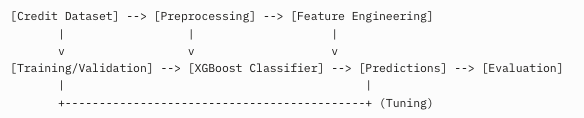


### Data Exploration and Preprocessing:

Load and inspect the dataset.

Clean and preprocess the data by handling missing values, encoding categorical variables, and scaling numerical features.

### Feature Engineering:

Create or modify features to better represent the underlying patterns in the data.

### Modeling:

* Train an XGBoost classifier on the data.

* Implement SMOTE to deal with imbalanced classes.

* Use GridSearchCV to tune hyperparameters for optimal model performance.

### Model Evaluation:

Evaluate the model using common metrics like ROC-AUC, Precision, Recall, F1-Score, and the confusion matrix.

Plot ROC curves to visualize model performance.


### Expected Outcome:

By the end of this project, the XGBoost classifier should be able to predict the likelihood of a customer defaulting on a loan with a high degree of accuracy and fairness, 
allowing stakeholders to take preemptive measures in assessing credit risk. 
The performance will be evaluated based on its ability to correctly predict defaults (sensitivity/recall) 
and the trade-off between precision and recall using metrics like ROC-AUC, Precision, and F1-Score.

## Potential Challenges and Considerations:

* Class Imbalance: The dataset may have more non-defaults than defaults, requiring careful handling with techniques like SMOTE to avoid biased predictions.

* Overfitting: XGBoost models are prone to overfitting, particularly on imbalanced datasets, so regularization techniques (e.g., reg_alpha, reg_lambda) will be applied.

* Future improvements: Feature Selection and Engineering will aid in the success of the model depends on identifying the most relevant features, and therefore careful feature engineering is important.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import xgboost as xgb
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import issparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import joblib

## 1. Create Postgres Database Connection & Load data to DataFrame

In [2]:
#Load Data from PostgreSQL
import pandas as pd
from sqlalchemy import create_engine

db_config = {
    "user": "INSERT",
    "password": "INSERT",
    "host": "localhost",
    "port": 5432,
    "database": "credit_etl"
}

engine = create_engine(f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")


1000

In [41]:
#load data 

query = "select * from raw.raw_customer_default_payment"

credit_data = pd.read_sql(query, engine)

credit_data.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2. Preprocess Data and Build ML Pipeline

In [17]:
x = credit_data.drop(columns= ['default_payment_next_month', 'id'])
y = credit_data['default_payment_next_month']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)



#categorical_cols = ['job', 'housing', 'purpose']
numerical_cols = credit_data

# Calculate the class weight ratio for imbalanced classes
class_weight_ratio = len(y_train) / (2 * y_train.value_counts().min())


#define the column transformer with OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    #('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), slice(0, x.shape[1]))
])


#smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='auto')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    #('smote',SMOTE(random_state=42)),#SMOTE to handle class imbalance
    #('selection', SelectKBest(score_func = f_classif, k=15)),
    ('clf', XGBClassifier(eval_metric='auc', random_state=42, scale_pos_weight=class_weight_ratio))
])


# Define the scoring method for cross-validation (AUC in this case)
scoring = make_scorer(roc_auc_score)

param_grid = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_depth': [3,5],
    'clf__learning_rate': [0.01, 0.05],
    'clf__subsample': [0.8],
    'clf__reg_alpha': [0, 0.3, 0.7],  # L1 regularization
    'clf__reg_lambda': [1, 10]      # L2 regularization
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           scoring=scoring, cv=cv, verbose=1, n_jobs=-1)

grid_search.fit(x_train, y_train)  # optional, suppress per-iteration output

best_params = grid_search.best_params_
print('Best Params:', best_params)
print("Best AUC:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(x_test)[:,1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {test_auc:.4f}")
                                 

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
Best AUC: 0.7073422195131627
AUC on test set: 0.7751


# 3. Model Evaluation

## Model iteration 1: Check for overfitting

### Step 1: Compare AUC on training vs test data — If there are any large gaps it may indicate overfitting

__Result:__

 __AUC on test set: 0.7667__   
 
 __V.S__   
 
 __Mean AUC from 10-fold CV: 0.7703__

The results you’ve shared indicate that your model's test AUC (0.7667) is very close to the mean AUC from 10-fold cross-validation (0.7703), which suggests that your model is not overfitting.

* Cross-validation AUC: The 10-fold cross-validation score (0.7703) is a good indicator of how your model is expected to generalize to unseen data. Since it's very close to the test set AUC (0.7667), 
it suggests that the model is not memorizing the training data but rather generalizing well.

* Consistency: The fact that both scores are similar indicates that the model is performing consistently on both the training data (during cross-validation) and unseen test data. This is a good sign that overfitting is not a major concern.

* Low variance between training (via cross-validation) and test AUC suggests that the model is generalizing well, meaning it doesn't memorize the training data and performs well on new, unseen data.

* Test AUC is not significantly lower than cross-validation AUC, so there's no indication that the model is overfitting.

In [32]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and compute mean AUC
cv_auc = cross_val_score(best_model, x_train, y_train, cv=10, scoring='roc_auc')
print(f"Mean AUC from 10-fold CV: {cv_auc.mean():.4f}")

Mean AUC from 10-fold CV: 0.7834


## Model iteration 2: Improve performance or check for minor overfitting

Tune Hyperparameters further to achieve higher performance:

Experimented with learning rate= decrease the rate to [0.01, 0.05] , max_depth= [3,5], regularization parameters=  L1 regularization to [0, 0.3, 0.7], for small gain in the AUC.

__AUC on test set: 0.7751__

__V.S__

__Mean AUC from 10-fold CV: 0.7834__

### Future tuning improvements

* __Feature Engineering:__ Add interaction terms between features or try feature selection to remove redundant or irrelevant features.

* __Model Complexity:__ You could try to reduce model complexity if you want to avoid any subtle overfitting. For example, reduce the number of estimators or max_depth.

* __Monitor AUC in Production:__ If you plan to deploy the model, continue monitoring its performance on new, unseen data to ensure that the model doesn't start overfitting over time as it gets exposed to more data.

### Step 2: Analysis the classification report

__Overall Performance__

__Accuracy:__ __80%__ reflects high performance on the dominant class (0), but can be misleading due to class imbalance.

__Macro Avg F1:__ 0.70 — unweighted average of F1 scores, showing class 1 underperforms.

__Weighted Avg F1:__ 0.80 — better than macro because it weighs the majority class more.

__AUC: 0.775__ — decent, but not ideal; it reflects the model’s ability to rank positives higher than negatives.

In [34]:
from sklearn.metrics import classification_report, roc_auc_score

# Get predicted labels for classification report
y_pred = best_model.predict(x_test)

# Get predicted probabilities for AUC score
y_pred_proba = best_model.predict_proba(x_test)[:, 1]

# Print classification report
creport2 = classification_report(y_test, y_pred)
print(creport2)

# Print AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC:", roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.47      0.61      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.71      0.69      6000
weighted avg       0.79      0.76      0.77      6000

Test AUC: 0.7791237997436249


### Interpretation

Your model is strong on the majority class (class 0), but struggles with the minority class (class 1).

Recall for class 1 is low (0.53) → many positives are being missed (false negatives).

Precision is also moderate for class 1 (0.54) → some false positives are also being predicted.



### Solution

__1. SMOTE:__

 * Apply SMOTE as random_state=42: ensures reproducibility. k_neighbors=5: number of nearest neighbors used to generate synthetic samples. Can be tuned (e.g., 3–10) depending on your dataset size.

 * sampling_strategy='auto': balances all classes to match the majority class.

__3. Scale the posituve weight__

* XGBoost expects this to help rebalance the contribution of the positive class.

* If your positive class = 1 (minority), and negative class = 0, use:

calculate = negatives / positives


These helps XGBoost focus more on the minority class, improving recall and AUC for imbalanced datasets.


In [31]:
# Calculate the scale weight ratio for imbalanced classes
from collections import Counter
counter = Counter(y_train) 

scale_weight_ratio = counter[0] / counter[1]


#define the column transformer with OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    #('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), slice(0, x.shape[1]))
])


smote = SMOTE(random_state=42, k_neighbors=2, sampling_strategy='auto')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote',SMOTE(random_state=42)),#SMOTE to handle class imbalance
    #('selection', SelectKBest(score_func = f_classif, k=15)),
    ('clf', XGBClassifier(eval_metric='auc', random_state=42, scale_pos_weight=scale_weight_ratio))
])


# Define the scoring method for cross-validation (AUC in this case)
scoring = make_scorer(roc_auc_score)

param_grid = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_depth': [3,5],
    'clf__learning_rate': [0.01, 0.05],
    'clf__subsample': [0.8],
    'clf__reg_alpha': [0, 0.3, 0.7],  # L1 regularization
    'clf__reg_lambda': [1, 10]      # L2 regularization
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           scoring=scoring, cv=cv, verbose=1, n_jobs=-1)

grid_search.fit(x_train, y_train)  # optional, suppress per-iteration output

best_params = grid_search.best_params_
print('Best Params:', best_params)
print("Best AUC:", grid_search.best_score_)


credit_best_model = grid_search.best_estimator_
y_pred_proba = credit_best_model.predict_proba(x_test)[:,1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {test_auc:.4f}")

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__reg_alpha': 0.3, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
Best AUC: 0.7171598584238785
AUC on test set: 0.7791


In [35]:
joblib.dump(best_model, 'credit_best_model_V1.pkl')

['credit_best_model_V1.pkl']

## AUC Improvements Noted - Increase Test AUC: 0.7791 from previous 0.7751

In [36]:

# Get predicted labels for classification report
y_pred = credit_best_model.predict(x_test)

# Get predicted probabilities for AUC score
y_pred_proba = credit_best_model.predict_proba(x_test)[:, 1]

# Print classification report
creport2 = classification_report(y_test, y_pred)
print(creport2)

# Print AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC:", roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.47      0.61      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.71      0.69      6000
weighted avg       0.79      0.76      0.77      6000

Test AUC: 0.7791237997436249


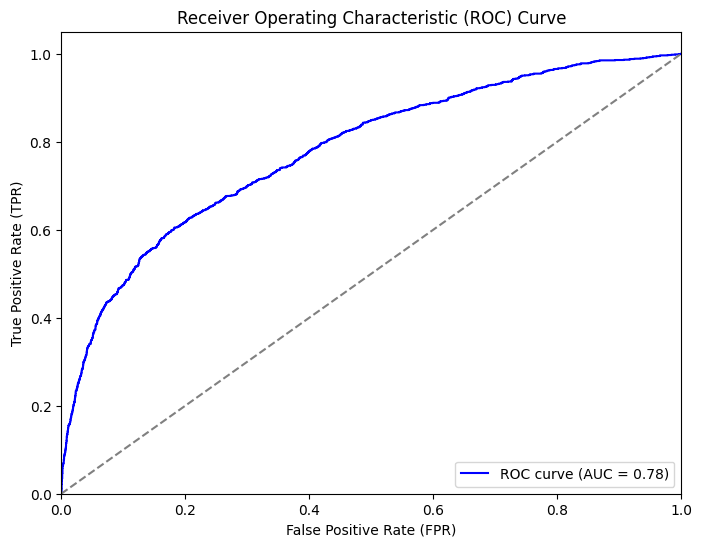

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
#y_pred_prob = model.predict_proba(x_test)[:, 1]  # Probabilities for class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Add saved model to MLflow

In [6]:
import mlflow.sklearn

mlflow.set_tracking_uri("http://localhost:5000")

#log model with flow
with mlflow.start_run() as run:
    mlflow.sklearn.log_model('credit_best_model_V1.pkl', artifact_path= 'credit_best_model_V1')
    #print(f"Run ID: {run.info.run_id}")

#register model

result = mlflow.register_model(
    model_uri=f"runs:/{run.info.run_id}/credit_best_model_V1",
    name="credit_score_model"
)


2025/05/10 10:38:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/10 10:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/10 10:38:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-flea-718 at: http://localhost:5000/#/experiments/0/runs/82c703632ba948708a19f62006a688a2.
2025/05/10 10:38:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
Successfully registered model 'credit_score_model'.
2025/05/10 10:38:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_score_model, version 1
Created version '1' of model 'credit_score_model'.
